In [1]:
"""Iterative reconstruction for masked polarization CMB data

    tests joint lensing gradient and cosmic birefringence potential reconstruction

    e.g. python ./param_joint.py -itmax 0 -v '' 


Testing with CMB lensing only reconstruction

srun python ./param_joint.py -k p_p -itmax 1 -v 'cmblensing_only' -cmb_version cmblensing_only -no_curl -no_birefringence

Testing with CMB lensing only reconstruction, new module

srun python ./param_joint.py -k p_p -itmax 1 -v 'cmblensing_only_joint' -joint_module -cmb_version cmblensing_only -no_curl -no_birefringence

python ./param_joint.py -k p_p -itmax 1 -v 'cmblensing_only_joint_v2' -joint_module -cmb_version cmblensing_only -no_curl -no_birefringence


Testing with CMB lensing only reconstruction, new module




"""


import os
from os.path import join as opj
import numpy as np
from psutil import cpu_count
import plancklens
from plancklens import utils
from plancklens import qresp
from plancklens import qest, qecl
from plancklens.qcinv import cd_solve
from plancklens.sims import phas, maps
from plancklens.sims.cmbs import sims_cmb_unl
from plancklens.filt import filt_simple, filt_util

from lenspyx.remapping.deflection import deflection
from lenspyx.remapping import utils_geom as utils_scarf
from lenspyx.remapping.utils_geom import Geom, pbdGeometry, pbounds
from lenspyx.utils import cli
from lenspyx.utils_hp import gauss_beam, almxfl, alm2cl, alm_copy
from lenspyx import cachers

from delensalot.utility import utils_steps
from delensalot.core.iterator import steps
from delensalot.core import mpi

from delensalot.core.iterator.cs_iterator_multi import iterator_cstmf as iterator_cstmf_wcurl

from jointmap.sims.sims_cmbs import sims_cmb_len
import healpy as hp

import argparse
from types import SimpleNamespace
import yaml

%reload_ext autoreload
%autoreload 2

def fg_phases(mappa: np.ndarray, seed: int = 0):
     np.random.seed(seed)
     f = lambda z: np.exp(1j*np.random.uniform(0., 2.*np.pi, size = z.shape))
     return f(mappa)

def randomizing_fg(mappa: np.ndarray, seed: int = 0):
     np.random.seed(seed)
     f = lambda z: np.abs(z) * np.exp(1j*np.random.uniform(0., 2.*np.pi, size = z.shape))
     return f(mappa)



import numpy as np

# Default values as defined by your parser:
defaults = {
    "config": None,
    "k": "p_p",
    "itmax": -1,
    "tol": 6.0,
    "imin": 0,
    "imax": 0,
    "v": "",
    "plot": False,
    "no_lensing": False,
    "no_curl": False,
    "no_birefringence": False,
    "no_tau": False,
    "ns": 1.0,
    "ACB": 7,
    "cmb_version": "",
    "joint_module": False,
    "lmax_unl": 4096,
    "mmax_unl": 4096,
    "lmax_qlm": 5120,
    "mmax_qlm": 5120,
    "Lmin": 1,
    "lmin_tlm": 1,
    "lmin_elm": 2,
    "lmin_blm": 200,
    "lmax_ivf": 4096,
    "mmax_ivf": 4096,
    "beam": 1.0,
    "nlev_t": 0.5 / np.sqrt(2),
    "selected": "ad p o",
    "randomize": False
}

class Args:
    def __init__(self, **kwargs):
        # Set defaults first
        for k, v in defaults.items():
            setattr(self, k, v)
        # Override with explicitly provided kwargs
        for k, v in kwargs.items():
            setattr(self, k, v)

simnumber = 70
args = Args(
    k="p_p",
    itmax=5,
    imin=simnumber,
    imax=simnumber,
    v="test_randomizing_new",
    joint_module=True,
    cmb_version="test_randomizing_new",
    no_curl=True,
    no_tau=True,
    no_birefringence=True,
    selected=["ad", "p", "o"],
    tol=6,
    beam=1.0,
    nlev_t=1.0,
    lmax_ivf=4000,
    mmax_ivf=4000,
    lmin_elm=30,
    lmin_blm=200,
    lmax_unl=4000,
    mmax_unl=4000,
    lmax_qlm=5120
)

# Demonstration of dot notation access:
print(args.tol)        # 6
print(args.k)          # "p_p"
print(args.lmax_unl)   # 4000 (overridden from default 4096)
print(args.selected)   # ["p", "o"]




config = {}
if args.config:
    with open(args.config, 'r') as file:
        config = yaml.safe_load(file)

merged_args = {**vars(args), **config}

args = SimpleNamespace(**merged_args)


randomize_function = (lambda x, idx: x) #if not args.randomize else randomizing_fg

def process_strings(strings):
    return list(map(lambda s: s[0] if len(s) == 2 else s, strings)), list(map(lambda s: len(s) == 2, strings))

selected = args.selected
selected, disabled = process_strings(selected)
disabled_dict = dict(zip(selected, disabled))
disable_function = (lambda x: disabled_dict[x] if x in disabled_dict else False)

print("Selected estimators (disabled operator?)", disabled_dict)


lmax_qlm, mmax_qlm = args.lmax_qlm, args.mmax_qlm # Lensing map is reconstructed down to this lmax and mmax
lmax_unl, mmax_unl = args.lmax_unl, args.mmax_unl  # Delensed CMB is reconstructed down to this lmax and mmax

nside = 2048
dlmax = 1024
lmax_unl_generation = 5000 #lmax for saving without CMBs

Lmin = args.Lmin

lmax_ivf, mmax_ivf, beam, nlev_t, nlev_p = (args.lmax_ivf, args.mmax_ivf, args.beam, args.nlev_t, args.nlev_t*np.sqrt(2))
lmin_tlm, lmin_elm, lmin_blm = (args.lmin_tlm, args.lmin_elm, args.lmin_blm) # The fiducial transfer functions are set to zero below these lmins
# for delensing useful to cut much more B. It can also help since the cg inversion does not have to reconstruct those.

lmax_transfer = lmax_ivf


zero_lensing = args.no_lensing
zero_birefringence = args.no_birefringence
zero_curl = args.no_curl
zero_tau = args.no_tau
cmb_version = args.cmb_version
joint_module = args.joint_module

if joint_module:
    from delensalot.core.opfilt.MAP_opfilt_iso_p_general import alm_filter_nlev_wl
    from delensalot.core.secondaries import secondaries
    from delensalot.core.iterator.cs_iterator_operator import iterator_cstmf as iterator_cstmf
else:
    from delensalot.core.opfilt.MAP_opfilt_iso_t import alm_filter_nlev_wl as alm_filter_nlev_wl_t
    from delensalot.core.opfilt.MAP_opfilt_iso_p import alm_filter_nlev_wl
    from delensalot.core.opfilt.MAP_opfilt_iso_tp import alm_filter_nlev_wl as alm_filter_nlev_wl_tp
    from delensalot.core.iterator.cs_iterator import iterator_cstmf as iterator_cstmf


suffix = cmb_version # descriptor to distinguish this parfile from others...
folder_ = "JOINTRECONSTRUCTION"
TEMP =  opj(os.environ['SCRATCH'], folder_, suffix)
DATDIR = opj(os.environ['SCRATCH'], folder_, suffix, 'sims')
DATDIRwcurl = opj(os.environ['SCRATCH'],folder_, suffix, 'simswcurl')
DATDIRwalpha = opj(os.environ['SCRATCH'],folder_, suffix, 'simswalpha')

if mpi.rank == 0:
    if not os.path.exists(DATDIR):
        os.makedirs(DATDIR)
mpi.barrier()
# harmonic space noise phas down to 4096
noise_phas = phas.lib_phas(opj(os.environ['SCRATCH'], 'noisephas_lmax%s'%(lmax_unl_generation)), 3, lmax_unl_generation) # T, E, and B noise phases

fields_of_interest = ['T', 'E', 'B', 'P', 'O', 'Alpha', 'Tau']
cmb_phas = phas.lib_phas(opj(os.environ['SCRATCH'], 'cmbphas_ncomps%s_lmax%s'%(len(fields_of_interest), lmax_unl_generation+dlmax)), len(fields_of_interest), lmax_unl_generation+dlmax) # unlensed T E B P O Alpha Tau, CMB phases


#----------------- pixelization and geometry info for the input maps and the MAP pipeline and for lensing operations
lenjob_geometry = Geom.get_thingauss_geometry(lmax_unl * 2, 2)

ninv_geom = lenjob_geometry #utils_scarf.Geom.get_thingauss_geometry(lmax_qlm + 500, 2)
#lenjob_geometry = ninv_geom
#ninv_geom = utils_scarf.Geom.get_thingauss_geometry(lmax_qlm + 100, 2)

lenjob_pbgeometry = pbdGeometry(lenjob_geometry, pbounds(0., 2 * np.pi))
Lmin = Lmin # The reconstruction of all lensing multipoles below that will not be attempted
mc_sims_mf_it0 = np.array([]) # sims to use to build the very first iteration mean-field (QE mean-field) Here 0 since idealized


# Multigrid chain descriptor
# The hard coded number nside here is irrelevant for diagonal preconditioner
chain_descrs = lambda lmax_sol, cg_tol : [[0, ["diag_cl"], lmax_sol, nside, np.inf, cg_tol, cd_solve.tr_cg, cd_solve.cache_mem()]]
recs_folder = TEMP+f"_version_{args.v}_recs"
libdir_iterators = lambda qe_key, simidx, version: opj(recs_folder,'%s_sim%04d'%(qe_key, simidx) + version)
#------------------


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

import copy


#"""
cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))

cls_unl_wcurl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]


ls = np.arange(cls_rot.size)
factor = cli(ls*(ls+1)/2)
cls_unl_wcurl["oo"] = cls_rot*factor**2.

#"""


# Fiducial CMB spectra for QE and iterative reconstructions
# (here we use very lightly suboptimal lensed spectra QE weights)
"""
cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_unl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cls_unl_wcurl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cls_unl_wcurl['oo'] = np.loadtxt(opj(cls_path, 'FFP10_fieldrotationCls.dat')) # lensing curl potential
cls_grad = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_gradlensedCls.dat'))
"""

cls_unl_walpha = copy.deepcopy(cls_unl_wcurl)



Nelements = 7999
for k, v in cls_unl_walpha.items():
    cls_unl_walpha[k] = v[:Nelements+1]


ell = np.arange(0, len(cls_unl_walpha["tt"])+1)
cls_alpha = 10**(-args.ACB)*2*np.pi/(ell*(ell+1))**args.ns
cls_alpha[0] = 0
cls_unl_walpha["aa"] = cls_alpha

HOME = os.environ['HOME']
tau_dir = opj(HOME, 'jointmap', 'data', 'tau_lensing_data')
tau_phi = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_ptau.txt"))
tau_tau = np.loadtxt(opj(tau_dir, "theory_spectra_optimistic_tautau.txt")) 
tau_tau[1] = cls_unl_walpha["pp"][1]
tau_phi[1] = cls_unl_walpha["pp"][1]
cls_unl_walpha["ff"] = tau_tau[:ell.size]
cls_unl_walpha["fp"] = tau_phi[:ell.size]*0.


print(cls_unl_walpha.keys())

"""
fields_ = ['p', 'f', 't', 'e', 'b', 'o', 'a']

result = {}
for i1, k1 in enumerate(fields_):
    for k2 in fields_[i1:]:
        if k1+k2 in cls_unl_walpha.keys():
            result[k1+k2] = cls_unl_walpha[k1+k2]
        elif k2+k1 in cls_unl_walpha.keys():
            result[k1+k2] = cls_unl_walpha[k2+k1]


cls_unl_walpha = copy.deepcopy(result)"""

print(cls_unl_walpha.keys())


# Fiducial model of the transfer function
transf_tlm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_tlm)
transf_elm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_elm)
transf_blm   =  gauss_beam(beam/180 / 60 * np.pi, lmax=lmax_ivf) * (np.arange(lmax_ivf + 1) >= lmin_blm)
transf_d = {'t':transf_tlm, 'e':transf_elm, 'b':transf_blm}
# Isotropic approximation to the filtering (used eg for response calculations)
ftl =  cli(cls_len['tt'][:lmax_ivf + 1] + (nlev_t / 180 / 60 * np.pi) ** 2 * cli(transf_tlm ** 2)) * (transf_tlm > 0)
fel =  cli(cls_len['ee'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_elm ** 2)) * (transf_elm > 0)
fbl =  cli(cls_len['bb'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_blm ** 2)) * (transf_blm > 0)

# Same using unlensed spectra (used for unlensed response used to initiate the MAP curvature matrix)
ftl_unl =  cli(cls_unl['tt'][:lmax_ivf + 1] + (nlev_t / 180 / 60 * np.pi) ** 2 * cli(transf_tlm ** 2)) * (transf_tlm > 0)
fel_unl =  cli(cls_unl['ee'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_elm ** 2)) * (transf_elm > 0)
fbl_unl =  cli(cls_unl['bb'][:lmax_ivf + 1] + (nlev_p / 180 / 60 * np.pi) ** 2 * cli(transf_blm ** 2)) * (transf_blm > 0)

# -------------------------
# ---- Input simulation libraries. Here we use the NERSC FFP10 CMBs with homogeneous noise and consistent transfer function
#       We define explictly the phase library such that we can use the same phases for for other purposes in the future as well if needed
#       I am putting here the phases in the home directory such that they dont get NERSC auto-purged
#       actual data transfer function for the sim generation:

transf_dat =  gauss_beam(beam / 180 / 60 * np.pi, lmax=lmax_transfer) # (taking here full FFP10 cmb's which are given to 4096)
cls_noise = {'t': np.full(lmax_transfer+1, (nlev_t /180 / 60 *  np.pi) ** 2)  * (cls_len['tt'][:lmax_transfer+1] > 0),
             'e': np.full(lmax_transfer+1, (nlev_p / 180 / 60 * np.pi) ** 2)  * (cls_len['ee'][:lmax_transfer+1] > 0),
             'b': np.full(lmax_transfer+1, (nlev_p / 180 / 60 * np.pi) ** 2)  * (cls_len['bb'][:lmax_transfer+1] > 0),}
cls_transf = {f: transf_dat for f in ['t', 'e', 'b']}

if mpi.rank ==0:
    # Problem of creating dir in parallel if does not exist
    #cacher = cachers.cacher_npy(DATDIR)
    #cacher_wcurl = cachers.cacher_npy(DATDIRwcurl)
    cacher_walpha = cachers.cacher_npy(DATDIRwalpha)
mpi.barrier()


#cmb_unl = sims_cmb_unl(cls_unl, cmb_phas)
#cmb_unl_wcurl = sims_cmb_unl(cls_unl_wcurl, cmb_phas)
#cmb_unl_walpha = sims_cmb_unl(cls_unl_walpha, cmb_phas)


#cmb_len = sims_cmb_len(DATDIR, lmax_transfer, cls_unl, lib_pha = cmb_phas, epsilon=1e-7, zerolensing = zero_lensing, zerobirefringence = zero_birefringence)
#cmb_len_wcurl = sims_cmb_len(DATDIRwcurl, lmax_transfer, cls_unl_wcurl, lib_pha = cmb_phas, epsilon=1e-7)

cmb_len_walpha = sims_cmb_len(DATDIRwalpha, lmax_unl_generation, cls_unl_walpha, lib_pha = cmb_phas, epsilon=1e-7, zerolensing = zero_lensing, zerobirefringence = zero_birefringence, zerocurl = zero_curl, zerotau = zero_tau, randomize_function = randomize_function)

#sims      = maps.cmb_maps_harmonicspace(cmb_len, cls_transf, cls_noise, noise_phas)
#sims_wcurl = maps.cmb_maps_harmonicspace(cmb_len_wcurl, cls_transf, cls_noise, noise_phas)

sims_walpha = maps.cmb_maps_harmonicspace(cmb_len_walpha, cls_transf, cls_noise, noise_phas)
# -------------------------

#ivfs         = filt_simple.library_fullsky_alms_sepTP(opj(recs_folder, 'ivfs'), sims, transf_d, cls_len, ftl, fel, fbl, cache=True)
#ivfs_wcurl   = filt_simple.library_fullsky_alms_sepTP(opj(recs_folder, 'ivfs_wcurl'), sims_wcurl, transf_d, cls_len, ftl, fel, fbl, cache=True)
ivfs_walpha  = filt_simple.library_fullsky_alms_sepTP(opj(recs_folder, 'ivfs_walpha'), sims_walpha, transf_d, cls_len, ftl, fel, fbl, cache=True)

# ---- QE libraries from plancklens to calculate unnormalized QE (qlms) and their spectra (qcls)
#mc_sims_bias = np.arange(0, dtype=int)
#mc_sims_var  = np.arange(0, 60, dtype=int)
#qlms_dd = qest.library_sepTP(opj(recs_folder, 'qlms_dd'), ivfs, ivfs,   cls_len['te'], 2048, lmax_qlm=lmax_qlm)
#qcls_dd = qecl.library(opj(recs_folder, 'qcls_dd'), qlms_dd, qlms_dd, mc_sims_bias)

mc_sims_bias = np.arange(0, dtype=int)
mc_sims_var  = np.arange(0, 60, dtype=int)

#qlms_dd_wcurl = qest.library_sepTP(opj(recs_folder, 'qlms_dd_wcurl'), ivfs_wcurl, ivfs_wcurl,   cls_len['te'], 2048, lmax_qlm=lmax_qlm)
#qcls_dd_wcurl = qecl.library(opj(recs_folder, 'qcls_dd_wcurl'), qlms_dd_wcurl, qlms_dd_wcurl, mc_sims_bias)

#library_jtTP
qlms_dd_walpha = qest.library_sepTP(opj(recs_folder, 'qlms_dd_walpha'), ivfs_walpha, ivfs_walpha,   cls_len['te'], 2048, lmax_qlm=lmax_qlm)
qcls_dd_walpha = qecl.library(opj(recs_folder, 'qcls_dd_walpha'), qlms_dd_walpha, qlms_dd_walpha, mc_sims_bias)

# -------------------------
# This following block is only necessary if a full, Planck-like QE lensing power spectrum analysis is desired
# This uses 'ds' and 'ss' QE's, crossing data with sims and sims with other sims.

# This remaps idx -> idx + 1 by blocks of 60 up to 300. This is used to remap the sim indices for the 'MCN0' debiasing term in the QE spectrum
ss_dict = { k : v for k, v in zip( np.concatenate( [ range(i*60, (i+1)*60) for i in range(0,5) ] ),
                                   np.concatenate( [ np.roll( range(i*60, (i+1)*60), -1 ) for i in range(0,5) ] ) ) }
ds_dict = { k : -1 for k in range(300)} # This remap all sim. indices to the data maps to build QEs with always the data in one leg

#ivfs_d = filt_util.library_shuffle(ivfs, ds_dict)
#ivfs_s = filt_util.library_shuffle(ivfs, ss_dict)

#qlms_ds = qest.library_sepTP(opj(TEMP, 'qlms_ds'), ivfs, ivfs_d, cls_len['te'], 2048, lmax_qlm=lmax_qlm)
#qlms_ss = qest.library_sepTP(opj(TEMP, 'qlms_ss'), ivfs, ivfs_s, cls_len['te'], 2048, lmax_qlm=lmax_qlm)

#qcls_ds = qecl.library(opj(TEMP, 'qcls_ds'), qlms_ds, qlms_ds, np.array([]))  # for QE RDN0 calculations
#qcls_ss = qecl.library(opj(TEMP, 'qcls_ss'), qlms_ss, qlms_ss, np.array([]))  # for QE RDN0 / MCN0 calculations


#qlms_ds_wcurl = qest.library_sepTP(opj(TEMP, 'qlms_ds_wcurl'), ivfs_wcurl, ivfs_d, cls_len['te'], 2048, lmax_qlm=lmax_qlm)
#qlms_ss_wcurl = qest.library_sepTP(opj(TEMP, 'qlms_ss_wcurl'), ivfs_wcurl, ivfs_s, cls_len['te'], 2048, lmax_qlm=lmax_qlm)

#qcls_ds_wcurl = qecl.library(opj(TEMP, 'qcls_ds_wcurl'), qlms_ds_wcurl, qlms_ds_wcurl, np.array([]))  # for QE RDN0 calculations
#qcls_ss_wcurl = qecl.library(opj(TEMP, 'qcls_ss_wcurl'), qlms_ss_wcurl, qlms_ss_wcurl, np.array([]))  # for QE RDN0 / MCN0 calculations


ivfs_d_walpha = filt_util.library_shuffle(ivfs_walpha, ds_dict)
ivfs_s_walpha = filt_util.library_shuffle(ivfs_walpha, ss_dict)

qlms_ds_walpha = qest.library_sepTP(opj(recs_folder, 'qlms_ds_walpha'), ivfs_walpha, ivfs_d_walpha, cls_len['te'], 2048, lmax_qlm=lmax_qlm)
qlms_ss_walpha = qest.library_sepTP(opj(recs_folder, 'qlms_ss_walpha'), ivfs_walpha, ivfs_s_walpha, cls_len['te'], 2048, lmax_qlm=lmax_qlm)

qcls_ds_walpha = qecl.library(opj(recs_folder, 'qcls_ds_walpha'), qlms_ds_walpha, qlms_ds_walpha, np.array([]))  # for QE RDN0 calculations
qcls_ss_walpha = qecl.library(opj(recs_folder, 'qcls_ss_walpha'), qlms_ss_walpha, qlms_ss_walpha, np.array([]))  # for QE RDN0 / MCN0 calculations


def get_n0_iter(k='p_p'):
    from plancklens import n0s
    fnN0s = 'N0siter' + k * (k != 'p_p')
    fndelcls = 'delcls'+ k * (k != 'p_p')
    cachecond = True
    if not cacher_wcurl.is_cached(fnN0s) or not cacher_wcurl.is_cached(fndelcls):
        _, N0sg, _, N0c, _, delcls = n0s.get_N0_iter(k, nlev_t, nlev_p, beam, cls_unl, {'t':lmin_tlm, 'e':lmin_elm, 'b':lmin_blm}, lmax_ivf,10, ret_delcls=True, ret_curl=True, lmax_qlm=lmax_qlm)
        if cachecond:
            cacher_wcurl.cache(fnN0s, np.array([N0sg, N0c]))
            cacher_wcurl.cache(fndelcls, np.array([delcls[-1][spec] for spec in ['ee', 'bb', 'pp']]))
        return np.array([N0sg, N0c]), delcls
    delcls =  cacher_wcurl.load(fndelcls)
    delclsdict = {'ee': delcls[0], 'bb':delcls[1], 'pp':delcls[2]}
    return cacher_wcurl.load(fnN0s), delclsdict


Using lenspyx alm2map
mpisupport: False, pmisupport: False
disabling mpi
6
p_p
4000
['ad', 'p', 'o']
Selected estimators (disabled operator?) {'a': True, 'p': False, 'o': False}


/tmp/ipykernel_20561/3778864651.py:307: RuntimeWarning: divide by zero encountered in divide
  cls_alpha = 10**(-args.ACB)*2*np.pi/(ell*(ell+1))**args.ns


dict_keys(['tt', 'ee', 'bb', 'te', 'pp', 'pt', 'pe', 'oo', 'aa', 'ff', 'fp'])
dict_keys(['tt', 'ee', 'bb', 'te', 'pp', 'pt', 'pe', 'oo', 'aa', 'ff', 'fp'])


/users/odarwish/pythonpackages/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


In [2]:
def get_n0_iter(k='p_p'):
    from plancklens import n0s
    fnN0s = 'N0siter' + k * (k != 'p_p')
    fndelcls = 'delcls'+ k * (k != 'p_p')
    cachecond = True
    if not cacher_wcurl.is_cached(fnN0s) or not cacher_wcurl.is_cached(fndelcls):
        _, N0sg, _, N0c, _, delcls = n0s.get_N0_iter(k, nlev_t, nlev_p, beam, cls_unl, {'t':lmin_tlm, 'e':lmin_elm, 'b':lmin_blm}, lmax_ivf,10, ret_delcls=True, ret_curl=True, lmax_qlm=lmax_qlm)
        if cachecond:
            cacher_wcurl.cache(fnN0s, np.array([N0sg, N0c]))
            cacher_wcurl.cache(fndelcls, np.array([delcls[-1][spec] for spec in ['ee', 'bb', 'pp']]))
        return np.array([N0sg, N0c]), delcls
    delcls =  cacher_wcurl.load(fndelcls)
    delclsdict = {'ee': delcls[0], 'bb':delcls[1], 'pp':delcls[2]}
    return cacher_wcurl.load(fnN0s), delclsdict

# -------------------------
def get_itlib(k:str, simidx:int, version:str, cg_tol:float):
    """Return iterator instance for simulation idx and qe_key type k
        Args:
            k: 'p_p' for Pol-only, 'ptt' for T-only, 'p_eb' for EB-only, etc
            simidx: simulation index to build iterative lensing estimate on
            version: string to use to test variants of the iterator with otherwise the same parfile
                     (here if 'noMF' is in version, will not use any mean-fied at the very first step)
            cg_tol: tolerance of conjugate-gradient filter
    """
    libdir_iterator = libdir_iterators(k, simidx, version)
    if not os.path.exists(libdir_iterator):
        os.makedirs(libdir_iterator)
    tr = int(os.environ.get('OMP_NUM_THREADS', cpu_count(logical=False)))
    print("Using %s threads"%tr)

    
    cpp = np.copy(cls_unl_walpha['pp'][:lmax_qlm + 1])
    cpp[:Lmin] *= 0.
    coo = np.copy(cls_unl_walpha['oo'][:lmax_qlm + 1])
    coo[:Lmin] *= 0.
    caa = np.copy(cls_unl_walpha['aa'][:lmax_qlm + 1])
    caa[:Lmin] *= 0.

    cff = np.copy(cls_unl_walpha['ff'][:lmax_qlm + 1]) #u is tau
    cff[:Lmin] *= 0.
    cpf = np.copy(cls_unl_walpha['fp'][:lmax_qlm + 1])
    cpf[:Lmin] *= 0.

    # QE mean-field fed in as constant piece in the iteration steps:

    qlms_dd_QE = qlms_dd_walpha
    sims_MAP = sims_walpha

    mf_sims = np.unique(mc_sims_mf_it0 if not 'noMF' in version else np.array([]))
    mf0_p = qlms_dd_QE.get_sim_qlm_mf('p' + k[1:], mf_sims)  # Mean-field to subtract on the first iteration:
    mf0_o = qlms_dd_QE.get_sim_qlm_mf('x' + k[1:], mf_sims)  # Mean-field to subtract on the first iteration:
    condition = (k == 'p_p')
    if condition:
        mf0_a = qlms_dd_QE.get_sim_qlm_mf('a' + k[1:], mf_sims)  # Mean-field to subtract on the first iteration:
        mf0_f = qlms_dd_QE.get_sim_qlm_mf('f' + k[1:], mf_sims)  # Mean-field to subtract on the first iteration:


    if simidx in mf_sims:  # We dont want to include the sim we consider in the mean-field...
        Nmf = len(mf_sims)
        mf0_p = (mf0_p - qlms_dd_QE.get_sim_qlm('p' + k[1:], int(simidx)) / Nmf) * (Nmf / (Nmf - 1))
        mf0_o = (mf0_o - qlms_dd_QE.get_sim_qlm('x' + k[1:], int(simidx)) / Nmf) * (Nmf / (Nmf - 1))
        if condition:
            mf0_a = (mf0_a - qlms_dd_QE.get_sim_qlm('a' + k[1:], int(simidx)) / Nmf) * (Nmf / (Nmf - 1))
            mf0_f = (mf0_f - qlms_dd_QE.get_sim_qlm('f' + k[1:], int(simidx)) / Nmf) * (Nmf / (Nmf - 1))

    plm0 = qlms_dd_QE.get_sim_qlm('p' + k[1:], int(simidx)) - mf0_p  # Unormalized quadratic estimate:
    olm0 = qlms_dd_QE.get_sim_qlm('x' + k[1:], int(simidx)) - mf0_o  # Unormalized quadratic estimate:
    if condition:
        alm0 = qlms_dd_QE.get_sim_qlm('a' + k[1:], int(simidx)) - mf0_a  # Unormalized quadratic estimate:
        flm0 = qlms_dd_QE.get_sim_qlm('f' + k[1:], int(simidx)) - mf0_f  # Unormalized quadratic estimate:

    # Isotropic normalization of the QE

    #NOTE: cls_grad!!!!
    Rpp, Roo = qresp.get_response('p' + k[1:], lmax_ivf, 'p', cls_len, cls_grad, {'e': fel, 'b': fbl, 't': ftl},
                                  lmax_qlm=lmax_qlm)[0:2]
    
    if condition:
        Raa = qresp.get_response('a' + k[1:], lmax_ivf, 'a', cls_len, cls_grad, {'e': fel, 'b': fbl, 't': ftl},
                                    lmax_qlm=lmax_qlm)[0]
        
        Rff = qresp.get_response('f' + k[1:], lmax_ivf, 'f', cls_len, cls_grad, {'e': fel, 'b': fbl, 't': ftl},
                                    lmax_qlm=lmax_qlm)[0]
    
    # Isotropic Wiener-filter (here assuming for simplicity N0 ~ 1/R)
    WF_p = cpp * utils.cli(cpp + utils.cli(Rpp))
    WF_o = coo * utils.cli(coo + utils.cli(Roo))
    if condition:
        WF_a = caa * utils.cli(caa + utils.cli(Raa))
        WF_f = cff * utils.cli(cff + utils.cli(Rff)) #is this the correct Wf in the presence of a cross-corr between tau and phi?

    plm0 = alm_copy(plm0, None, lmax_qlm, mmax_qlm)  # Just in case the QE and MAP mmax'es were not consistent
    almxfl(plm0, utils.cli(Rpp), mmax_qlm, True)  # Normalized QE
    np.save(libdir_iterator+"/plm0_norm.npy", plm0)
    almxfl(plm0, WF_p, mmax_qlm, True)  # Wiener-filter QE
    almxfl(plm0, cpp > 0, mmax_qlm, True)

    def process_xlm0(xlm0, Rxx, Wxx, cxx, nome):
        xlm0 = alm_copy(xlm0, None, lmax_qlm, mmax_qlm)  # Just in case the QE and MAP mmax'es were not consistent
        almxfl(xlm0, utils.cli(Rxx), mmax_qlm, True)  # Normalized QE
        np.save(libdir_iterator+f"/{nome}_norm.npy", xlm0)
        almxfl(xlm0, Wxx, mmax_qlm, True)  # Wiener-filter QE
        almxfl(xlm0, cxx > 0, mmax_qlm, True)
        return xlm0


    shift_1, shift_2 = 1000, 2000
    """plm0_12 = qlms_dd_QE.get_sim_qlm('p' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_2) - mf0_p
    plm0_21 = qlms_dd_QE.get_sim_qlm('p' + k[1:], int(simidx), shift_1 = shift_2, shift_2 = shift_1) - mf0_p"""
    plm0_11 = qlms_dd_QE.get_sim_qlm('p' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_1) - mf0_p
    plm0_22 = qlms_dd_QE.get_sim_qlm('p' + k[1:], int(simidx), shift_1 = shift_2, shift_2 = shift_2) - mf0_p
    """plm0_12 = process_xlm0(plm0_12, Rpp, WF_p, cpp > 0, "plm0_12")
    plm0_21 = process_xlm0(plm0_21, Rpp, WF_p, cpp > 0, "plm0_21")"""
    plm0_11 = process_xlm0(plm0_11, Rpp, WF_p, cpp > 0, "plm0_11")
    plm0_22 = process_xlm0(plm0_22, Rpp, WF_p, cpp > 0, "plm0_22")


    olm0 = alm_copy(olm0, None, lmax_qlm, mmax_qlm)  # Just in case the QE and MAP mmax'es were not consistent
    almxfl(olm0, utils.cli(Roo), mmax_qlm, True)  # Normalized QE
    np.save(libdir_iterator+"/olm0_norm.npy", olm0)
    almxfl(olm0, WF_o, mmax_qlm, True)  # Wiener-filter QE assuming the curl signal is the expected one
    almxfl(olm0, coo > 0, mmax_qlm, True)

    """olm0_12 = qlms_dd_QE.get_sim_qlm('x' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_2) - mf0_o
    olm0_21 = qlms_dd_QE.get_sim_qlm('x' + k[1:], int(simidx), shift_1 = shift_2, shift_2 = shift_1) - mf0_o"""
    olm0_11 = qlms_dd_QE.get_sim_qlm('x' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_1) - mf0_o
    olm0_22 = qlms_dd_QE.get_sim_qlm('x' + k[1:], int(simidx), shift_1 = shift_2, shift_2 = shift_2) - mf0_o

    """olm0_12 = process_xlm0(olm0_12, Roo, WF_o, coo > 0, "olm0_12")
    olm0_21 = process_xlm0(olm0_21, Roo, WF_o, coo > 0, "olm0_21")"""
    olm0_11 = process_xlm0(olm0_11, Roo, WF_o, coo > 0, "olm0_11")
    olm0_22 = process_xlm0(olm0_22, Roo, WF_o, coo > 0, "olm0_22")


    if condition:
        alm0 = alm_copy(alm0, None, lmax_qlm, mmax_qlm)  # Just in case the QE and MAP mmax'es were not consistent
        almxfl(alm0, utils.cli(Raa), mmax_qlm, True)  # Normalized QE
        np.save(libdir_iterator+"/alm0_norm.npy", alm0)
        almxfl(alm0, WF_a, mmax_qlm, True)  # Wiener-filter QE
        almxfl(alm0, caa > 0, mmax_qlm, True)

        """alm0_12 = qlms_dd_QE.get_sim_qlm('a' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_2) - mf0_p
        alm0_21 = qlms_dd_QE.get_sim_qlm('a' + k[1:], int(simidx), shift_1 = shift_2, shift_2 = shift_1) - mf0_p"""
        alm0_11 = qlms_dd_QE.get_sim_qlm('a' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_1) - mf0_p
        alm0_22 = qlms_dd_QE.get_sim_qlm('a' + k[1:], int(simidx), shift_1 = shift_2, shift_2 = shift_2) - mf0_p

        """alm0_12 = process_xlm0(alm0_12, Raa, WF_a, cpp > 0, "alm0_12")
        alm0_21 = process_xlm0(alm0_21, Raa, WF_a, cpp > 0, "alm0_21")"""
        alm0_11 = process_xlm0(alm0_11, Raa, WF_a, cpp > 0, "alm0_11")
        alm0_22 = process_xlm0(alm0_22, Raa, WF_a, cpp > 0, "alm0_22")
        

        flm0 = alm_copy(flm0, None, lmax_qlm, mmax_qlm)  # Just in case the QE and MAP mmax'es were not consistent
        almxfl(flm0, utils.cli(Rff), mmax_qlm, True)  # Normalized QE
        np.save(libdir_iterator+"/flm0_norm.npy", flm0)
        almxfl(flm0, WF_f, mmax_qlm, True)  # Wiener-filter QE
        almxfl(flm0, cff > 0, mmax_qlm, True)

        """flm0_12 = qlms_dd_QE.get_sim_qlm('f' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_2) - mf0_p
        flm0_21 = qlms_dd_QE.get_sim_qlm('f' + k[1:], int(simidx), shift_1 = shift_2, shift_2 = shift_1) - mf0_p"""
        #flm0_12 = process_xlm0(flm0_12, Raa, WF_a, cpp > 0, "flm0_12")
        #flm0_21 = process_xlm0(flm0_21, Raa, WF_a, cpp > 0, "flm0_21")

        flm0_11 = qlms_dd_QE.get_sim_qlm('f' + k[1:], int(simidx), shift_1 = shift_1, shift_2 = shift_1) - mf0_p
        flm0_11 = process_xlm0(flm0_11, Raa, WF_a, cpp > 0, "flm0_11")

    Rpp_unl, Roo_unl = qresp.get_response('p' + k[1:], lmax_ivf, 'p', cls_unl, cls_unl,
                                          {'e': fel_unl, 'b': fbl_unl, 't': ftl_unl}, lmax_qlm=lmax_qlm)[0:2]

    if condition:
        Raa_unl = qresp.get_response('a' + k[1:], lmax_ivf, 'a', cls_unl, cls_unl,
                                        {'e': fel_unl, 'b': fbl_unl, 't': ftl_unl}, lmax_qlm=lmax_qlm)[0]
        
        Rff_unl = qresp.get_response('f' + k[1:], lmax_ivf, 'f', cls_unl, cls_unl,
                                        {'e': fel_unl, 'b': fbl_unl, 't': ftl_unl}, lmax_qlm=lmax_qlm)[0]

        Rpf_unl, Rof_unl = qresp.get_response('p' + k[1:], lmax_ivf, 'f', cls_unl, cls_unl,
                                            {'e': fel_unl, 'b': fbl_unl, 't': ftl_unl}, lmax_qlm=lmax_qlm)[0:2]
        
        Rpa_unl, Roa_unl = qresp.get_response('p' + k[1:], lmax_ivf, 'a', cls_unl, cls_unl,
                                            {'e': fel_unl, 'b': fbl_unl, 't': ftl_unl}, lmax_qlm=lmax_qlm)[0:2]
        
        Rap_unl, Rao_unl = qresp.get_response('a' + k[1:], lmax_ivf, 'p', cls_unl, cls_unl,
                                        {'e': fel_unl, 'b': fbl_unl, 't': ftl_unl}, lmax_qlm=lmax_qlm)[0:2]

        Rfp_unl = qresp.get_response('f' + k[1:], lmax_ivf, 'p', cls_unl, cls_unl,  
                                        {'e': fel_unl, 'b': fbl_unl, 't': ftl_unl}, lmax_qlm=lmax_qlm)[0]

        print("Rfp_unl", Rfp_unl.shape)
    
    # Lensing deflection field instance (initiated here with zero deflection)

    ffi = deflection(lenjob_geometry, np.zeros_like(plm0), mmax_qlm, numthreads=tr, epsilon=1e-7)

    #list of fields....
    #then create matrices
    names = ["p", "a", "o", "f"]

    if condition:
        signal_dictionary = {"pp": cpp, "oo": coo, "aa": caa, "pf": cpf*0, "ff": cff}
        response_dictionary = {"pp": Rpp_unl, "oo": Roo_unl, "aa": Raa_unl, "pf": Rfp_unl, "pf": Rpf_unl, "ff": Rff_unl}
    else:
        signal_dictionary = {"pp": cpp, "oo": coo}
        response_dictionary = {"pp": Rpp_unl, "oo": Roo_unl}

        
    Nselected = len(selected)

    signal_matrix = np.zeros((cpp.size, Nselected, Nselected))
    response_matrix = np.zeros_like(signal_matrix)

    for i, m in enumerate(selected):
        for j, l in enumerate(selected):
            key = l + m
            if key in signal_dictionary.keys():
                print("key", key)
                signal_matrix[..., i, j] = signal_dictionary[key]
            elif key[::-1] in signal_dictionary.keys():
                print("reverse key", key[::-1])
                signal_matrix[..., i, j] = signal_dictionary[key[::-1]]

            if key in response_dictionary.keys():
                response_matrix[..., i, j] = response_dictionary[key]
            #elif key[::-1] in response_dictionary.keys():
            #    response_matrix[..., i, j] = response_dictionary[key[::-1]]

    non_zero = (cpp>0)*(coo>0)
    inv_signal_matrix = np.zeros_like(signal_matrix)
    inv_signal_matrix[non_zero, ...] = np.linalg.inv(signal_matrix[non_zero, ...])

    total_inv_curvature_matrix = inv_signal_matrix + response_matrix

    print("Response matrix shape", response_matrix.shape)

    non_zero = (Rpp>0)
    total_curvature_matrix = np.zeros_like(total_inv_curvature_matrix)
    total_curvature_matrix[non_zero, ...] = np.linalg.inv(total_inv_curvature_matrix[non_zero, ...])
    total_curvature_matrix = np.nan_to_num(total_curvature_matrix)
    cpp_mask = (cpp > 0)
    cpp_mask = cpp_mask[:, np.newaxis, np.newaxis]
    pp_h0s_matrix = total_curvature_matrix * cpp_mask
    inv_signal_matrix = inv_signal_matrix * cpp_mask

    #np.save("pp_h0s_matrix.npy", pp_h0s_matrix)


    chh = cpp[:lmax_qlm+1]
    hh_h0 = cli(Rpp_unl[:lmax_qlm + 1] + cli(chh))  #~ (1/Cpp + 1/N0)^-1
    hh_h0 *= (chh > 0)


    doshift = True

    if condition:
        starting_points_dictionary = {"p": plm0, "a": alm0, "o": olm0, "f": flm0}
        if doshift:
            starting_points_dictionary_12 = {"p": plm0_11, "a": alm0_11, "o": olm0_11, "f": flm0_11}
            #starting_points_dictionary_21 = {"p": plm0_21, "a": alm0_21, "o": olm0_21, "f": flm0_21}
    else:
        starting_points_dictionary = {"p": plm0, "a": alm0}
        starting_points_dictionary_12 = {"p": plm0_11, "a": alm0_11}
        #starting_points_dictionary_21 = {"p": plm0_21, "a": alm0_21}

    plm0 = np.concatenate([starting_points_dictionary[key] for key in selected])

    if doshift:
        plm0_12 = np.concatenate([starting_points_dictionary_12[key] for key in selected])
        #plm0_21 = np.concatenate([starting_points_dictionary_21[key] for key in selected])
        plm0_21 = None
    else:
        plm0_12 = None
        plm0_21 = None
    
    if k in ['p_p']:
        if joint_module:
            
            LensingOp = secondaries.Lensing(name = "p", lmax = ffi.lmax_dlm, mmax = ffi.mmax_dlm, sht_tr = tr, disable = disable_function("p"))
            LensingOp.set_field(ffi)

            CurlLensingOp = secondaries.Lensing(name = "o", lmax = ffi.lmax_dlm, mmax = ffi.mmax_dlm, sht_tr = tr, disable = disable_function("o"))
            CurlLensingOp.set_field(ffi)

            RotationOp = secondaries.Rotation(name = "a", lmax = lmax_qlm, mmax = mmax_qlm, sht_tr = tr, disable = disable_function("a"))
            alpha_map = ninv_geom.synthesis(plm0, spin = 0, lmax = lmax_qlm, mmax = mmax_qlm, nthreads = 128).squeeze()
            RotationOp.set_field(np.zeros_like(alpha_map))

            PatchyTauOp = secondaries.PatchyTau(name = "f", lmax = ffi.lmax_dlm, mmax = ffi.mmax_dlm, sht_tr = tr, disable = disable_function("f"))
            PatchyTauOp.set_field(np.zeros_like(alpha_map))

            operators_dictionary = {"p": LensingOp, "o": CurlLensingOp, "a": RotationOp, "f": PatchyTauOp}

            #in principle I should just have a deflection field, then I could set up properties of this deflection field
            #properties would include gradient and curl parts
            ignore_calling = ["o"] if "p" in selected else [] 

            Operator = secondaries.Operators([operators_dictionary[oper] for oper in selected], ignore_calling = ignore_calling)

            print("Operators are", Operator.names)

            filtr = alm_filter_nlev_wl(ninv_geom, nlev_p, transf_elm, (lmax_unl, mmax_unl), (lmax_ivf, mmax_ivf),
                                        transf_b=transf_blm, nlev_b=nlev_p, operators = Operator)
            
        else:
            # Here multipole cuts are set by the transfer function (those with 0 are not considered)
            filtr = alm_filter_nlev_wl(nlev_p, ffi, transf_elm, (lmax_unl, mmax_unl), (lmax_ivf, mmax_ivf),
                                        transf_b=transf_blm, nlev_b=nlev_p)
        # dat maps must now be given in harmonic space in this idealized configuration
        eblm = np.array(sims_MAP.get_sim_pmap(int(simidx)))
        datmaps = np.array([alm_copy(eblm[0], None, lmax_ivf, mmax_ivf), alm_copy(eblm[1], None, lmax_ivf, mmax_ivf) ])
        del eblm
        wflm0 = lambda: alm_copy(ivfs_walpha.get_sim_emliklm(simidx), None, lmax_unl, mmax_unl)
    elif k in ['p']:
        filtr = alm_filter_nlev_wl_tp(nlev_t, nlev_p, ffi, transf_tlm, (lmax_unl, mmax_unl), (lmax_ivf, mmax_ivf),
                                    transf_b=transf_blm, transf_e=transf_elm)
        # dat maps must now be given in harmonic space in this idealized configuration
        eblm = np.array(sims_MAP.get_sim_pmap(int(simidx)))
        tlm = sims_MAP.get_sim_tmap(int(simidx))
        datmaps = np.array([alm_copy(tlm, None, lmax_ivf, mmax_ivf),
                            alm_copy(eblm[0], None, lmax_ivf, mmax_ivf),
                            alm_copy(eblm[1], None, lmax_ivf, mmax_ivf)])
        del tlm, eblm
        wflm0 = lambda: np.array([alm_copy(ivfs_walpha.get_sim_tmliklm(simidx), None, lmax_unl, mmax_unl),
                                  alm_copy(ivfs_walpha.get_sim_emliklm(simidx), None, lmax_unl, mmax_unl)])

    elif k in ['ptt']:
        # Here multipole cuts are set by the transfer function (those with 0 are not considered)
        filtr = alm_filter_nlev_wl_t(nlev_t, ffi, transf_tlm, (lmax_unl, mmax_unl), (lmax_ivf, mmax_ivf))
        # dat maps must now be given in harmonic space in this idealized configuration
        tlm = sims_MAP.get_sim_tmap(int(simidx))
        datmaps = alm_copy(tlm, None, lmax_ivf, mmax_ivf)
        del tlm
        wflm0 = lambda: alm_copy(ivfs_walpha.get_sim_tmliklm(simidx), None, lmax_unl, mmax_unl)

    else:
        assert 0


    k_geom = filtr.ffi.geom if not joint_module else LensingOp.field.geom # Customizable Geometry for position-space operations in calculations of the iterated QEs etc


    if 'wcurl' in version:
        # Sets to zero all L-modes below Lmin in the iterations:
        stepper = utils_steps.harmonicbump(xa=400, xb=1500)
        iterator = iterator_cstmf_wcurl(libdir_iterator, 'p', [(lmax_qlm, mmax_qlm), (lmax_qlm, mmax_qlm)], datmaps,
                                  [plm0, olm0], [mf0_p, mf0_o], [Rpp_unl, Roo_unl], [cpp, coo], ('p', 'x'), cls_unl, filtr, k_geom,
                                  chain_descrs(lmax_unl, cg_tol), stepper,
                                 wflm0=wflm0)

    else: # standard gradient only
        stepper = steps.harmonicbump(lmax_qlm, mmax_qlm, xa=400, xb=1500, a = 0.5, b = 0.1, scale = 50)  # reduce the gradient by 0.5 for large scale and by 0.1 for small scales to improve convergence in regimes where the deflection field is not invertible
        step_val = 0.5
        stepper = steps.nrstep(lmax_qlm, mmax_qlm, val = step_val)
        
        if joint_module:
            stepper = steps.nrstep(lmax_qlm, mmax_qlm, val = step_val, vals = [step_val]*len(Operator.names))
            iterator = iterator_cstmf(libdir_iterator, 'p', (lmax_qlm, mmax_qlm), datmaps,
                plm0, plm0 * 0, Rpp_unl, cpp, cls_unl, filtr, k_geom, chain_descrs(lmax_unl, cg_tol), stepper
                , wflm0=lambda : alm_copy(ivfs_walpha.get_sim_emliklm(simidx), None, lmax_unl, mmax_unl), 
                pp_h0s_matrix = pp_h0s_matrix, inv_signal_matrix = inv_signal_matrix, plm0_12 = plm0_12, plm0_21 = plm0_21, sims_lib = sims_walpha,
                idx = simidx, itmax = args.itmax)
        else:
            iterator = iterator_cstmf(libdir_iterator, 'p', (lmax_qlm, mmax_qlm), datmaps,
                plm0, plm0 * 0, Rpp_unl, cpp, cls_unl, filtr, k_geom, chain_descrs(lmax_unl, cg_tol), stepper
                , wflm0=lambda : alm_copy(ivfs_walpha.get_sim_emliklm(simidx), None, lmax_unl, mmax_unl))
    return iterator

In [29]:


tol_iter   = lambda it : 10 ** (- args.tol) # tolerance a fct of iterations ?
soltn_cond = lambda it: True # Uses (or not) previous E-mode solution as input to search for current iteration one


mpi.barrier = lambda : 1 # redefining the barrier (Why ? )
from delensalot.core.iterator.statics import rec as Rec
jobs = []
#for idx in range(args.imin, args.imax+1):
for idx in [simnumber]:
    lib_dir_iterator = libdir_iterators(args.k, idx, args.v)
    if Rec.maxiterdone(lib_dir_iterator) < args.itmax or args.plot:
        jobs.append(idx)

if mpi.rank ==0:
    print("Caching things in " + TEMP)


Caching things in /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new


In [30]:
for idx in jobs[mpi.rank::mpi.size]:
    lib_dir_iterator = libdir_iterators(args.k, idx, args.v)
    print("iterator folder: " + lib_dir_iterator)

    if args.itmax >= 0 and Rec.maxiterdone(lib_dir_iterator) < args.itmax:
        itlib = get_itlib(args.k, idx, args.v, 1.)
        for i in range(args.itmax + 1):
            print("****Iterator: setting cg-tol to %.4e ****"%tol_iter(i))
            print("****Iterator: setting solcond to %s ****"%soltn_cond(i))
            itlib.chain_descr  = chain_descrs(lmax_unl, tol_iter(i))
            itlib.soltn_cond   = soltn_cond(i)
            print("doing iter " + str(i))
            itlib.iterate(i, 'p')

iterator folder: /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim0070test_randomizing_new
Using 20 threads
Shift name is /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/qlms_dd_walpha/sim_p_p_0070_1000_1000.fits
Shift name is /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/qlms_dd_walpha/sim_p_p_0070_2000_2000.fits
Shift name is /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/qlms_dd_walpha/sim_x_p_0070_1000_1000.fits
Shift name is /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/qlms_dd_walpha/sim_x_p_0070_2000_2000.fits
Shift name is /scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/qlms_dd_walpha/sim_a_p_0070_1000_1000.fits
Shift name is /scratch/snx3000/odarwish/JOI

OSError: 39344643 requested and 0 written

In [20]:
import scipy

def bin_theory(cl, bin_edges):
    l = np.arange(len(cl))
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    el = (bin_edges[1:] + bin_edges[:-1])/2
    return el, cl


bin_edges = np.arange(10, 4000, 20)


def cross_corr_coeff(a, b, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = x**2 / (aa * bb)
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr

bin_edges_A = np.arange(1, 10, 1)
bin_edges_B = np.arange(10, 500, 100)
bin_edges = np.concatenate([bin_edges_A, bin_edges_B, np.arange(500, 4000, 200)])

decorator = lambda x: bin_theory(x, bin_edges)

In [ ]:
directory = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim{simnumber:04}test_randomizing_new/hessian/"

#f = np.load(directory+"rlm_sn_0_p.npy")
#f1000 = np.load(directory+"rlm_sn_0_p_1000_1000.npy")

directory = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim{simnumber:04}test_randomizing_new/"

root = "plm_gradplik_it000"
#root = "phi_plm_it000"
#roots = ["plm_gradplik_it000", "phi_plm_it000"]

roots = ["phi_plm_it000"]+[f"hessian/rlm_sn_{i}_p" for i in range(3)]

#roots = ["plm_gradplik_it000"]

alpha_lm = hp.read_alm("/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new/simswalpha/sim_0070_alpha_lm.fits")
alpha_lm = utils.alm_copy(alpha_lm, lmax = lmax_qlm)
fs = np.cumsum([np.load(directory+f"{root}.npy") for root in roots], axis = 0)
fs1000 = np.cumsum([np.load(directory+f"{root}_1000_1000.npy") for root in roots], axis = 0)

/tmp/ipykernel_20561/97417832.py:12: RuntimeWarning: invalid value encountered in divide
  correction = -hp.alm2cl(alpha_lm)/hp.alm2cl(alpha_lm, ff)


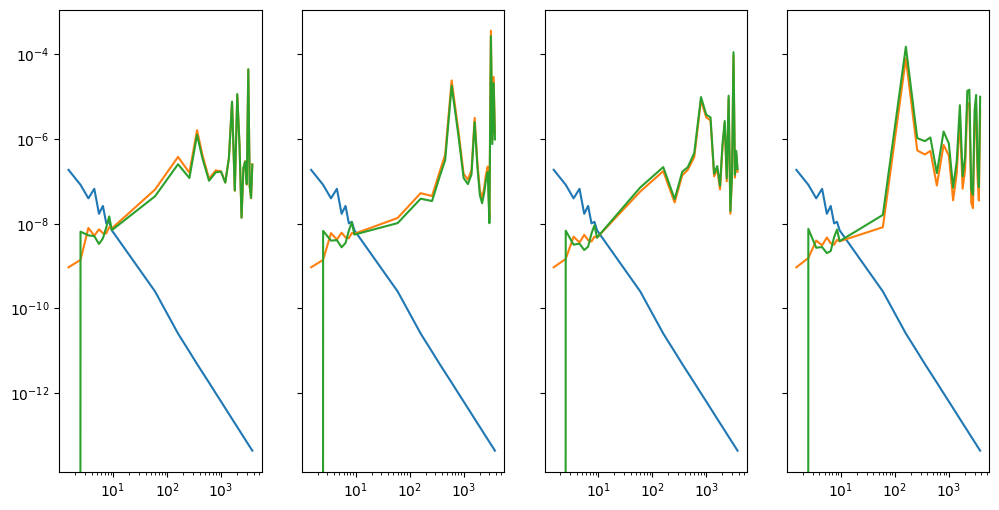

In [31]:
import matplotlib.pyplot as plt

N = len(roots)
fig, axs = plt.subplots(ncols = N, sharey=True, figsize = (12, 6))
axs = [axs] if N == 1 else axs

for i in range(N):
    xx = 0
    ff = np.split(fs[i], 3)[xx]
    ff1000 = np.split(fs1000[i], 3)[xx]

    correction = -hp.alm2cl(alpha_lm)/hp.alm2cl(alpha_lm, ff)
    
    N0 = hp.alm2cl(ff1000)*correction**2

    input = hp.alm2cl(alpha_lm)
    el, clth = decorator(input)
    axs[i].loglog(el, clth)
    el, cl = decorator(hp.alm2cl(ff)*correction**2-input)
    axs[i].loglog(el, cl)

    el, noise = decorator(N0)
    axs[i].loglog(el, noise)
    
plt.show()

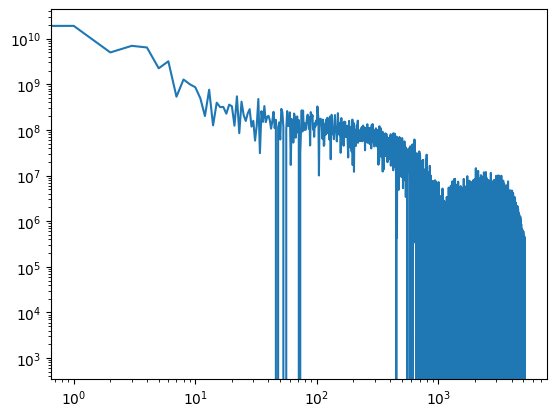

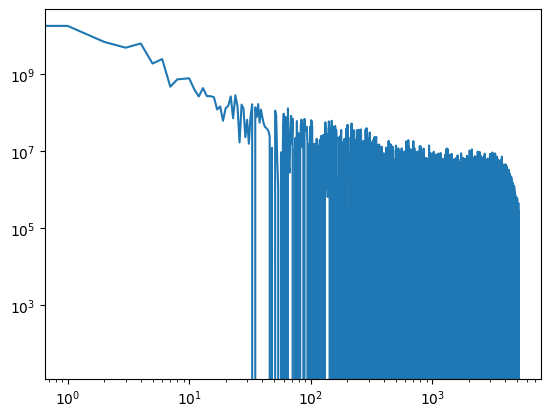

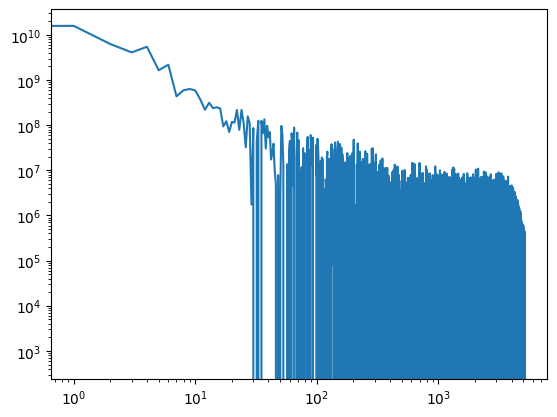

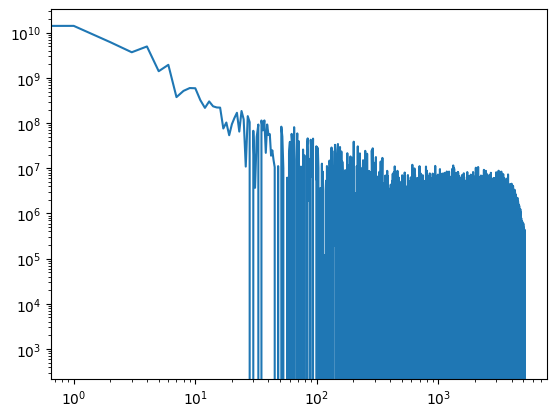

In [12]:
for i in range(1, 5):
    
    glm = np.load(f"glm_{i}.npy")
    glm_shifted = np.load(f"glm_shifted_{i}.npy")
    
    glm = np.split(glm, 3)[0]
    glm_shifted = np.split(glm_shifted, 3)[0]

    #plt.loglog(hp.alm2cl(glm))
    #plt.loglog(hp.alm2cl(glm_shifted))
    plt.loglog(hp.alm2cl(glm)-hp.alm2cl(glm_shifted))
    

    plt.show()

In [37]:
directory = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim{simnumber:04}test_randomizing_new/hessian/"

#f = np.load(directory+"rlm_sn_0_p.npy")
#f1000 = np.load(directory+"rlm_sn_0_p_1000_1000.npy")

directory = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/test_randomizing_new_version_test_randomizing_new_recs/p_p_sim{simnumber:04}test_randomizing_new/"

root = "plm_gradplik_it000"
#root = "phi_plm_it000"
roots = ["plm_gradplik_it000", "phi_plm_it000"]

f = np.load(directory+f"{root}.npy")
f1000 = np.load(directory+f"{root}_1000_1000.npy")

xx = 0
f = np.split(f, 3)[xx]
f1000 = np.split(f1000, 3)[xx]

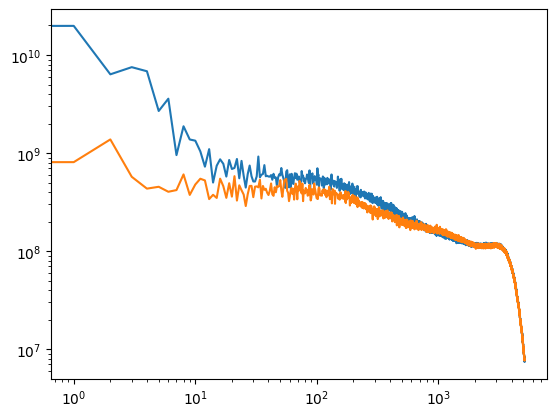

In [39]:
import matplotlib.pyplot as plt


roots = ["plm_gradplik_it000"]#, "phi_plm_it000"]
for root in roots:
    f = np.load(directory+f"{root}.npy")
    f1000 = np.load(directory+f"{root}_1000_1000.npy")

    xx = 0
    f = np.split(f, 3)[xx]
    f1000 = np.split(f1000, 3)[xx]
    plt.loglog(hp.alm2cl(f))#/hp.alm2cl(f1000))
    plt.loglog(hp.alm2cl(f1000))


In [5]:
from plancklens import shts

def fg_phases(mappa: np.ndarray, seed: int = 0):
    np.random.seed(seed)
    f = lambda z: np.exp(1j*np.random.uniform(0., 2.*np.pi, size = z.shape))
    return f(mappa)

In [6]:
#eblm_dat_map_ = np.load("eblm_dat_map.npy")
#eblm_wf_map_ = np.load("eblm_wf_map.npy")

eblm_dat_map = np.load("eblm_dat_map_0.npy")
eblm_wf_map = np.load("eblm_wf_map_0.npy")

eblm_dat_map_1000 = np.load("eblm_dat_map_1000.npy")
eblm_wf_map_1300 = np.load("eblm_wf_map_1000.npy")

In [7]:
#eblm_dat_map_lm = ninv_geom.adjoint_synthesis(eblm_dat_map.copy(), 2, lmax_ivf, mmax_ivf, 24)
#eblm_dat_map_lm_ = ninv_geom.adjoint_synthesis(eblm_dat_map_.copy(), 2, lmax_ivf, mmax_ivf, 24)

In [8]:
#plt.loglog(hp.alm2cl(eblm_dat_map_lm[0]))
#plt.loglog(hp.alm2cl(eblm_dat_map_lm_[0]))

#what's the matter with the data maps???
#something wrong with sims??

In [29]:
def get(eblm_dat_map, eblm_wf_map, seedA, seedB):
    gc = eblm_dat_map[0] * eblm_wf_map[0] + eblm_dat_map[1] * eblm_wf_map[1]
    which = "a"
    gc *= (-1)**(which == "a")
    gc_lm = ninv_geom.adjoint_synthesis(gc.copy(), 0, lmax_qlm, mmax_qlm, 24).squeeze()
    eblm_dat_map_lm = ninv_geom.adjoint_synthesis(eblm_dat_map.copy(), 2, lmax_ivf, mmax_ivf, 24)
    eblm_wf_map_lm = ninv_geom.adjoint_synthesis(eblm_wf_map.copy(), 2, lmax_ivf, mmax_ivf, 24)
    phases = fg_phases(eblm_dat_map_lm[0], seed = seedA)
    phases_B = fg_phases(eblm_dat_map_lm[0], seed = seedB)
    eblm_dat_map_lm_rand = eblm_dat_map_lm * phases
    eblm_wf_map_lm_rand = eblm_wf_map_lm * phases_B
    eblm_dat_map_rand = ninv_geom.synthesis(eblm_dat_map_lm_rand, 2, lmax_ivf, mmax_ivf, 24)
    eblm_wf_map_rand = ninv_geom.synthesis(eblm_wf_map_lm_rand, 2, lmax_ivf, mmax_ivf, 24)
    gc_rand = eblm_dat_map_rand[0] * eblm_wf_map_rand[0] + eblm_dat_map_rand[1] * eblm_wf_map_rand[1]
    gc_rand_lm = ninv_geom.adjoint_synthesis(gc_rand, 0, lmax_qlm, mmax_qlm, 24).squeeze()
    return gc_lm, gc_rand_lm 

In [30]:
seed1, seed2 = 1000, 1003
gc_lm_A, gc_rand_lm_A = get(eblm_dat_map, eblm_wf_map, seed1, seed2)
gc_lm_B, gc_rand_lm_B = get(eblm_dat_map, eblm_wf_map, seed2, seed1)

In [31]:
clsA, cls_randA = hp.alm2cl(gc_lm_A), hp.alm2cl(gc_rand_lm_A)
clsB, cls_randB = hp.alm2cl(gc_lm_B), hp.alm2cl(gc_rand_lm_B)
cls_randcross = hp.alm2cl(gc_rand_lm_A, gc_rand_lm_B)
cls_randsum = hp.alm2cl(gc_rand_lm_A+gc_rand_lm_B)*0.5

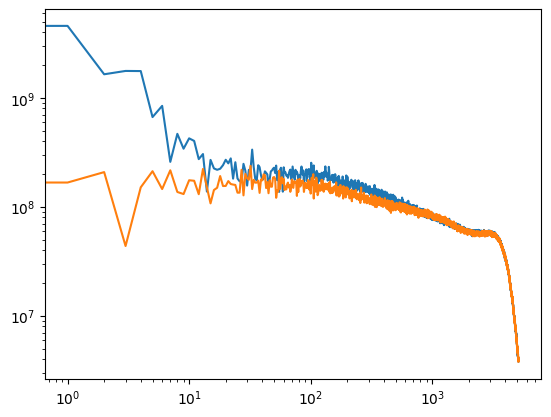

In [26]:
import matplotlib.pyplot as plt

plt.loglog(clsA)
plt.loglog(cls_randA)
#plt.loglog(cls_randB)
#plt.loglog(cls_randcross)
#plt.loglog(cls_randsum)

#plt.loglog(cls_)
#plt.loglog(cls_rand_)